In [24]:
import csv
import psycopg2
import numpy as np
from scipy.stats import entropy
from itertools import product
import matplotlib.style as style
import matplotlib.pyplot as plt


In [25]:
functions = ['avg', 'sum', 'max', 'min', 'count']
attributes = [
    'workclass',
    'education',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native_country',
    'economic_indicator'
]
measures = [
    'age',
    'fnlwgt',
    'education_num',
    'capital_gain',
    'capital_loss',
    'hours_per_week'
]

In [26]:
def get_all_views():
    views=[]
    for f in functions:
        for a in attributes:
            for m in measures:
                views.append((a,f,m))
    return views

In [27]:

def kl_distance(target, reference):

    tar_list = list(target)
    ref_list = list(reference)

    attributes = set()
    tar_values, ref_values = [], []

    for attribute, value in tar_list:
        attributes.add(attribute)
    for attribute, value in ref_list:
        attributes.add(attribute)

    for attribute in attributes:
        tgt_val = next((val for key, val in tar_list if key == attribute), 0)
        ref_val = next((val for key, val in ref_list if key == attribute), 0)
        tar_values.append(tgt_val)
        ref_values.append(ref_val)

    tar_total = sum(tar_values) or 1.0
    ref_total = sum(ref_values) or 1.0
    tar_probs = [float(val) / tar_total for val in tar_values]
    ref_probs = [float(val) / ref_total for val in ref_values]

    epsilon = 1e-10
    tar_probs = [max(probability, epsilon) for probability in tar_probs]
    ref_probs = [max(probability, epsilon) for probability in ref_probs]

    kld = entropy(tar_probs, ref_probs)

    return kld


In [44]:
def hoeffding_serfling(phase, num_phases, delta):
    phase = float(phase)
    num_phases = float(phase)  # Note: This should probably be float(num_phases)
    
    term1 = 1 - ((phase - 1) / num_phases)
    term2 = 2 * np.log(np.log(phase)) + np.log((np.pi * np.pi) / (3 * delta))
    
    numerator = term1 * term2
    denominator = 2 * phase
    
    epsilon_m = np.sqrt(numerator / denominator)
    
    return epsilon_m

In [29]:
def visualize(cursor, top_k_views):
    for view, utility_score in top_k_views:
        a,f,m = view
        tar_query = "SELECT {}, {}({}) FROM married GROUP BY {};".format(a, f, m, a)
        cursor.execute(tar_query)
        tar_data = cursor.fetchall()

        ref_query = "SELECT {}, {}({}) FROM unmarried GROUP BY {};".format(a, f, m, a)
        cursor.execute(ref_query)
        ref_data = cursor.fetchall()

        tar_attributes = set(row[0] for row in tar_data)
        ref_attributes = set(row[0] for row in ref_data)

        combined_attributes = tar_attributes.union(ref_attributes)

        tar_values = []
        for attribute in combined_attributes:
            value = next((row[1] for row in tar_data if row[0] == attribute), 0)
            tar_values.append(value)

        ref_values = []
        for attribute in combined_attributes:
            value = next((row[1] for row in ref_data if row[0] == attribute), 0)
            ref_values.append(value)

        fig, ax = plt.subplots()

        bar_width=0.35
        index = np.arange(len(combined_attributes))

        ax.bar(index, tar_values, bar_width, color='green', label='Married')

        ax.bar(index + bar_width, ref_values, bar_width, color='hotpink', label='Unmarried')
        ax.set_xlabel(f"{a}(KL Divergence = {utility_score})")
        ax.set_ylabel(f"{f}({m})")
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(combined_attributes, rotation=45)
        ax.legend()

    plt.show()

In [30]:
def get_partition_size(cur, num_partitions):
    cur.execute('select count(*) from census;')
    total_entries = cursor.fetchone()[0]
    partition_size = 1 + total_entries / num_partitions
    return partition_size

In [31]:
connection = psycopg2.connect("dbname=seedb user=postgres password=sachin")
cursor = connection.cursor()

all_views = get_all_views()

## Naive

In [32]:
def naive_search(cur, all_views, offset=-1, limit_val=-1, top_k=5):

    results = list()
    if offset!=-1:
        limit_range = "LIMIT {} OFFSET {}".format(limit_val, (offset*limit_val))
    else:
        limit_range = ""

    for view in all_views:
        a, f, m = view
        tar_query = "SELECT {}, {}({}) FROM married GROUP BY {} {};".format(a, f, m, a, limit_range)

        cur.execute(tar_query)
        tar_output = cur.fetchall()

        ref_query = "SELECT {}, {}({}) FROM unmarried GROUP BY {} {};".format(a, f, m, a, limit_range)
        cur.execute(ref_query)
        ref_output = cur.fetchall()

        utility_score = kl_distance(tar_output, ref_output)
        results.append((view, utility_score))


    sorted_results = sorted(results, key=lambda x: x[1], reverse=True)

    top_k_results = sorted_results[:top_k]

    return top_k_results


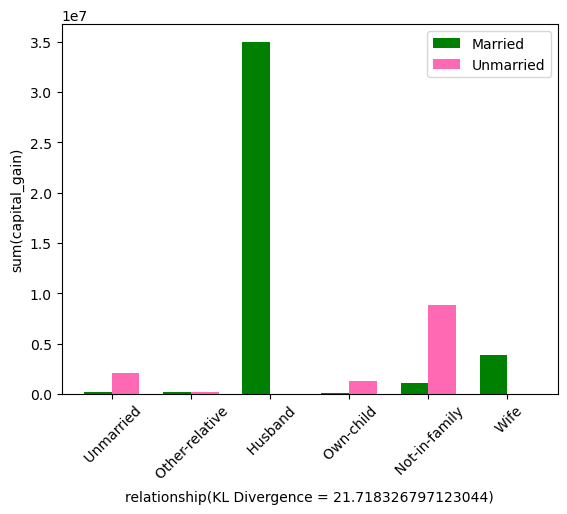

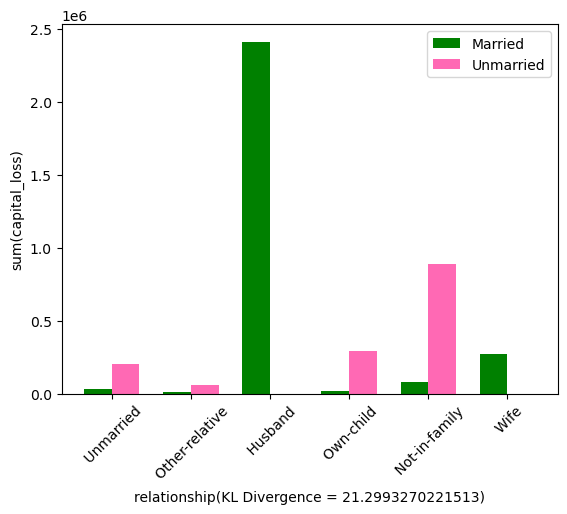

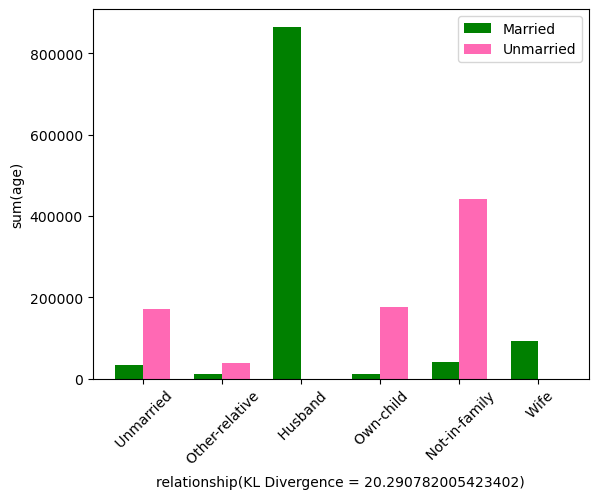

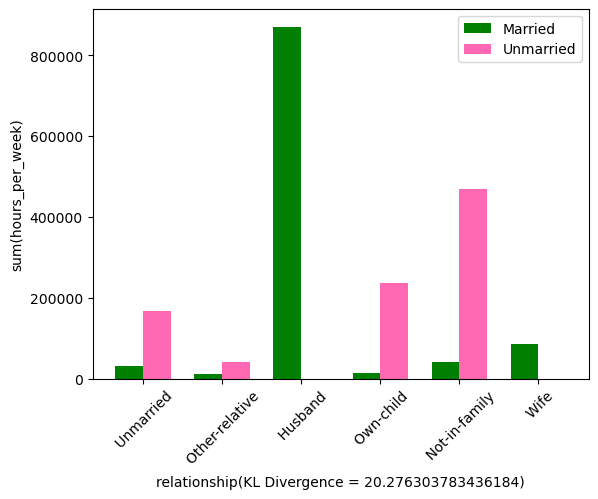

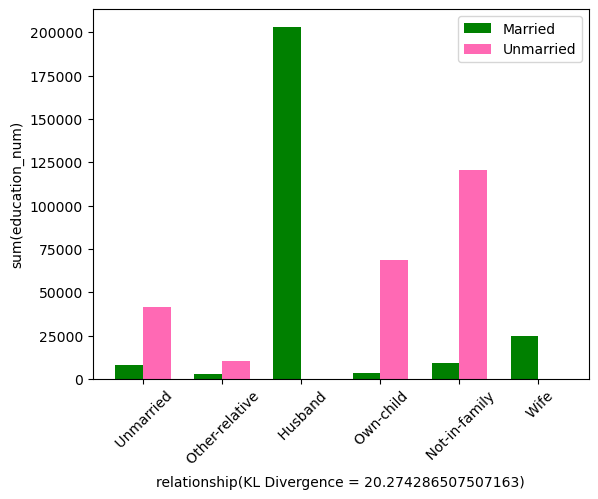

CPU times: total: 484 ms
Wall time: 25.6 s


In [33]:
%%time
top_k_views = naive_search(cursor, all_views, -1, -1)
visualize(cursor, top_k_views)

## Sharing Based

In [34]:
def sharing_based_optimization(cur, all_views, offset=-1, limit_val=-1, top_k=5):

    results = list()

    if offset!=-1:
        limit_range = "LIMIT {} OFFSET {}".format(limit_val, (offset*limit_val))
    else:
        limit_range = ""

    for attribute in attributes:
        m_agg_list = []
        attribute_views = []
        for view in all_views:
            a,f,m = view
            if a == attribute:
                attribute_views.append(view)
                m_agg_list.append("{}({})".format(f, m))

        if len(m_agg_list)==0:
            continue
        m_aggregate=", ".join(m_agg_list)

        

        tar_query = "SELECT {}, {} FROM married GROUP BY {} {};".format(attribute, m_aggregate, attribute, limit_range)
        cur.execute(tar_query)
        tar_output = cur.fetchall()

        ref_query = "SELECT {}, {} FROM unmarried GROUP BY {} {};".format(attribute, m_aggregate, attribute, limit_range)
        cur.execute(ref_query)
        ref_output = cur.fetchall()

        for i, view in enumerate(attribute_views):
            tar_results = []
            ref_results = []
            for val in tar_output:
                tar_results.append((val[0], val[i+1]))
            for val in ref_output:
                ref_results.append((val[0], val[i+1]))
        
            dist = kl_distance(tar_results, ref_results)
            results.append((view, dist))

    sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
    top_k_results = sorted_results[:top_k]

    return top_k_results


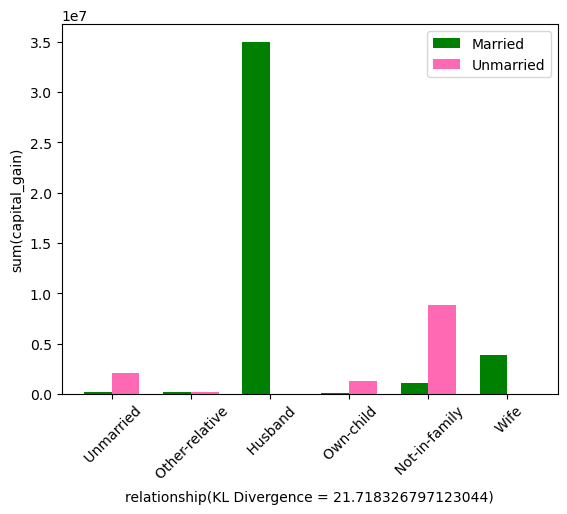

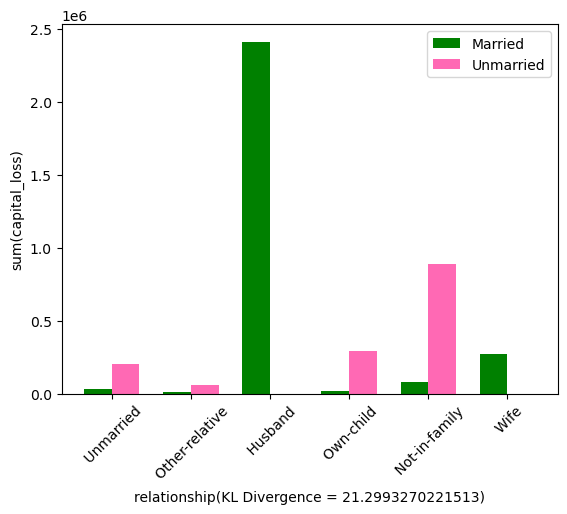

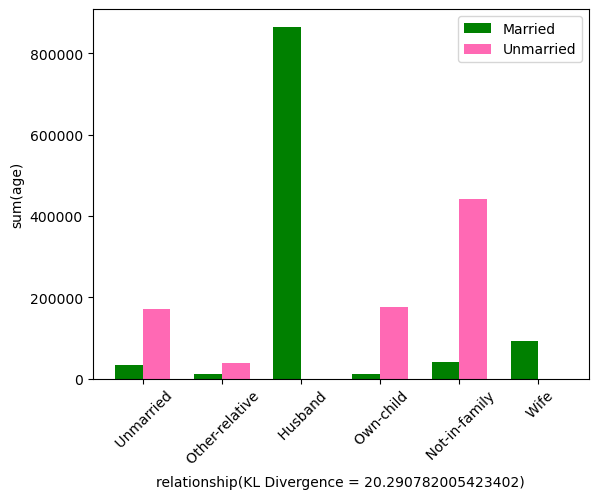

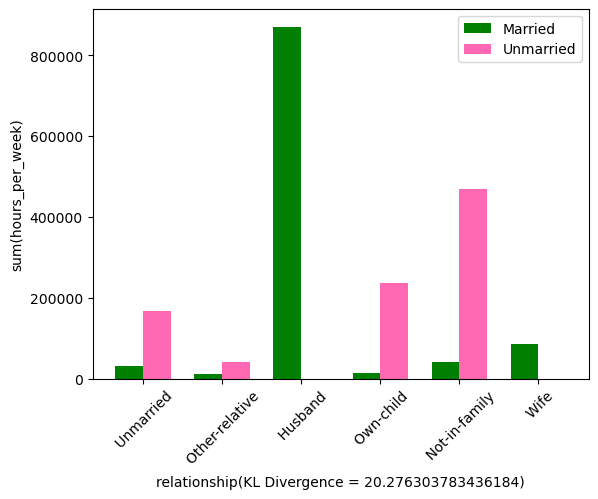

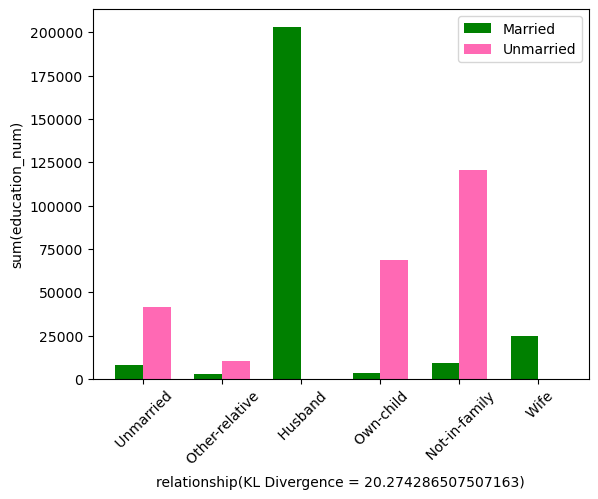

CPU times: total: 438 ms
Wall time: 2.12 s


In [35]:
%%time
top_k_views = sharing_based_optimization(cursor, all_views, -1, -1)
visualize(cursor, top_k_views)

## Combine Target and Reference View

In [36]:
def combine_tar_ref_query(cur, all_views, offset=-1, limit_val=-1, top_k=5):

    results = list()
    if offset!=-1:
        limit_range = "LIMIT {} OFFSET {}".format(limit_val, (offset*limit_val))
    else:
        limit_range = ""
    
    for attribute in attributes:
        m_agg_list = []
        attribute_views = []
        for view in all_views:
            a,f,m = view
            if a == attribute:
                attribute_views.append(view)
                m_agg_list.append("{}({})".format(f, m))
        if len(m_agg_list)==0:
            continue
        m_aggregate=", ".join(m_agg_list)

        combined_query = "SELECT {}, {}, CASE WHEN marital_status IN (' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent', ' Separated') THEN 1 ELSE 0 END AS marital_group FROM census GROUP BY {}, marital_group {};".format(attribute, m_aggregate, attribute, limit_range)

        cur.execute(combined_query)
        combined_output = cur.fetchall()
        
        for i, view in enumerate(attribute_views):
            tar_results = []
            ref_results = []
            for val in combined_output:
                if(val[-1]==1):
                    tar_results.append((val[0], val[i+1]))
                else:
                    ref_results.append((val[0], val[i+1]))
            dist = kl_distance(tar_results, ref_results)
            results.append((view, dist))

    sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
    top_k_results = sorted_results[:top_k]

    return top_k_results
    

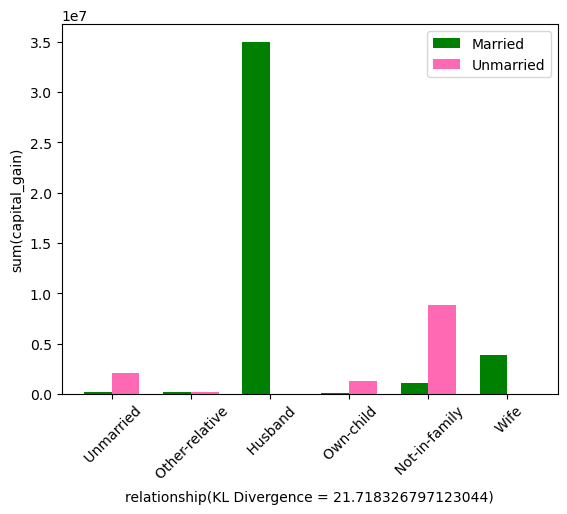

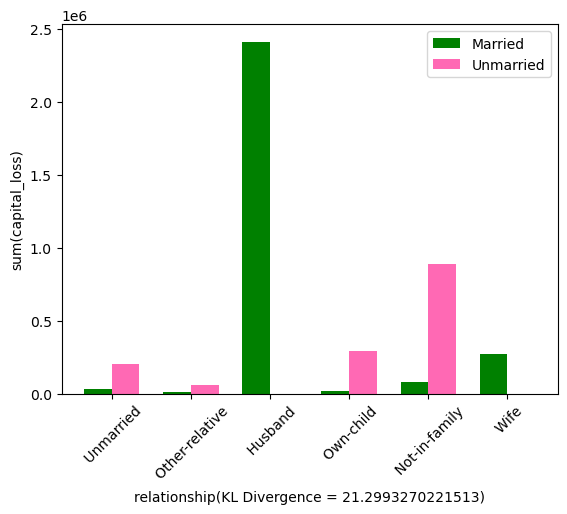

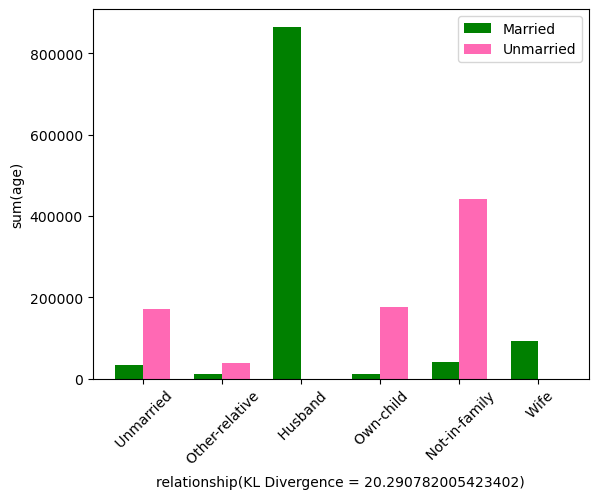

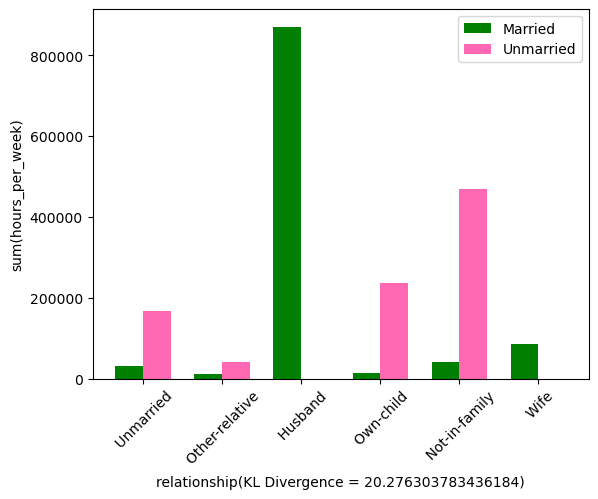

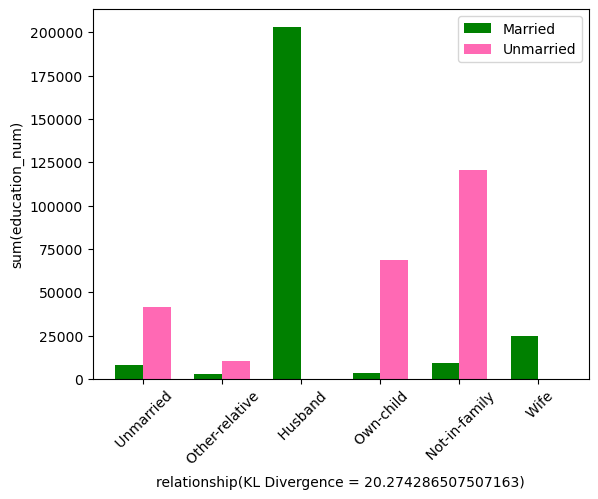

CPU times: total: 469 ms
Wall time: 2 s


In [37]:
%%time
top_k_views = combine_tar_ref_query(cursor, all_views, -1, -1)
visualize(cursor, top_k_views)

## Multiple Group Bys

In [38]:
def sharing_based_multiple_group_by(cur, all_views, offset=-1, limit_val=-1, top_k=5):

    results = list()

    if offset!=-1:
        limit_range = "LIMIT {} OFFSET {}".format(limit_val, (offset*limit_val))
    else:
        limit_range = ""

    m_agg_list = set()
    attribute_views = []
    fm_set = set()
    for view in all_views:
        a,f,m = view
        m_agg_list.add("{}({})".format(f, m))
        fm_set.add((f,m))

    m_aggregate=", ".join(m_agg_list)
    a_list=", ".join(attributes)

    funcs_list = list(m_agg_list)
    fm_list = list(fm_set)
    sorted_funcs_list = sorted(funcs_list)
    sorted_fm_list = sorted(fm_list)


    tar_result_dict = {}
    for item1 in attributes:
        tar_result_dict[item1] = {}
        
        for item2 in m_agg_list:
            tar_result_dict[item1][item2] = []


    ref_result_dict = {}
    for item1 in attributes:
        ref_result_dict[item1] = {}
        
        for item2 in m_agg_list:
            ref_result_dict[item1][item2] = []

    tar_query = "SELECT {}, {} FROM married GROUP BY GROUPING SETS ({}) {};".format(a_list, m_aggregate, a_list, limit_range)
    cur.execute(tar_query)
    tar_output = cur.fetchall()

    ref_query = "SELECT {}, {} FROM unmarried GROUP BY GROUPING SETS ({}) {};".format(a_list, m_aggregate, a_list, limit_range)
    cur.execute(ref_query)
    ref_output = cur.fetchall()

    attr_index=0
    for row in tar_output:
        if row[attr_index]==None:
            attr_index+=1
        for j in range(8,37,1):
            tar_result_dict[attributes[attr_index]][funcs_list[j-8]].append((row[attr_index],row[j]))
        
    attr_index=0
    for row in ref_output:
        if row[attr_index]==None:
            attr_index+=1
        for j in range(8,37,1):
            ref_result_dict[attributes[attr_index]][funcs_list[j-8]].append((row[attr_index],row[j]))

    results=[]

    for attribute in attributes:
        tar_values=[]
        ref_values=[]
        for num, func in enumerate(sorted_funcs_list):
            tar_values = tar_result_dict[attribute][func]
            ref_values = ref_result_dict[attribute][func]
            utility_score = kl_distance(tar_values, ref_values)
            f,m = sorted_fm_list[num]
            results.append(((attribute,f,m), utility_score))
    
    sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
    top_k_results = sorted_results[:top_k]

    return top_k_results


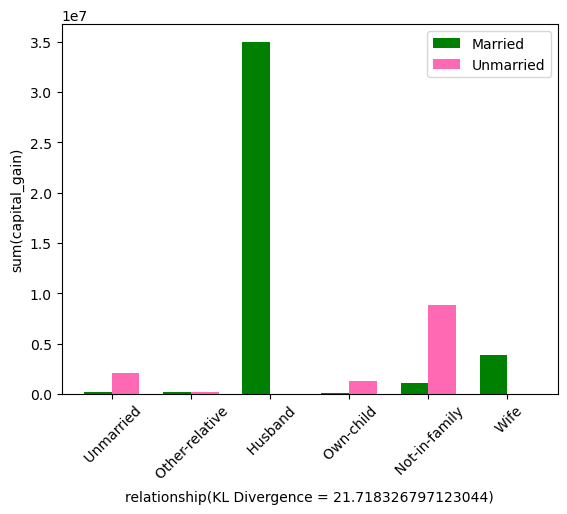

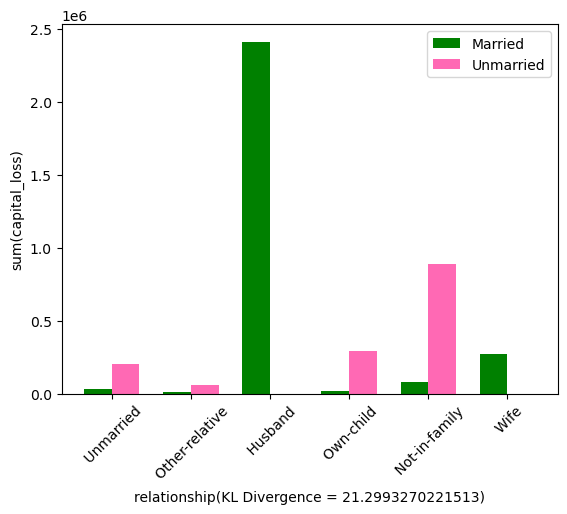

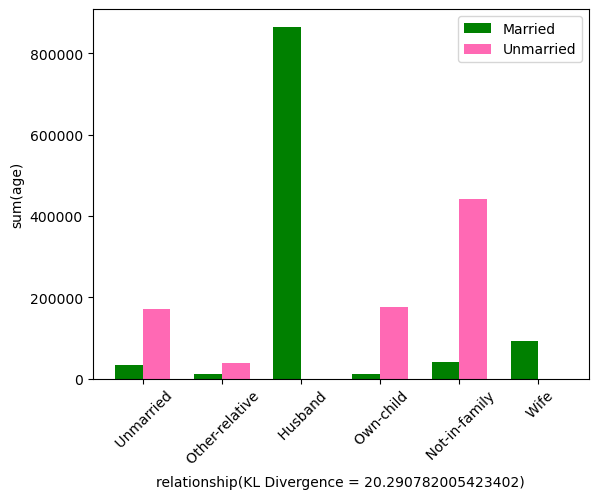

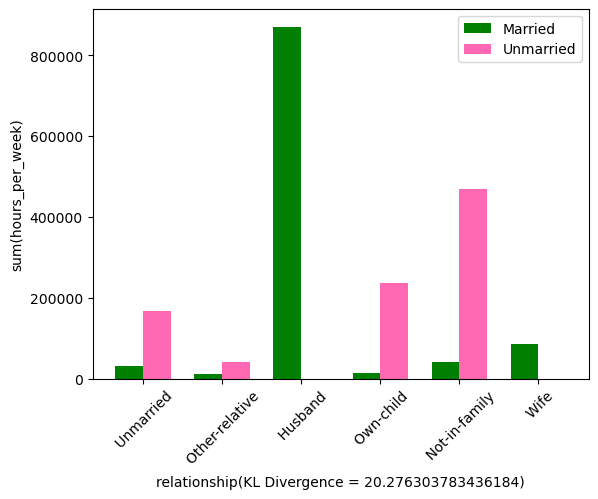

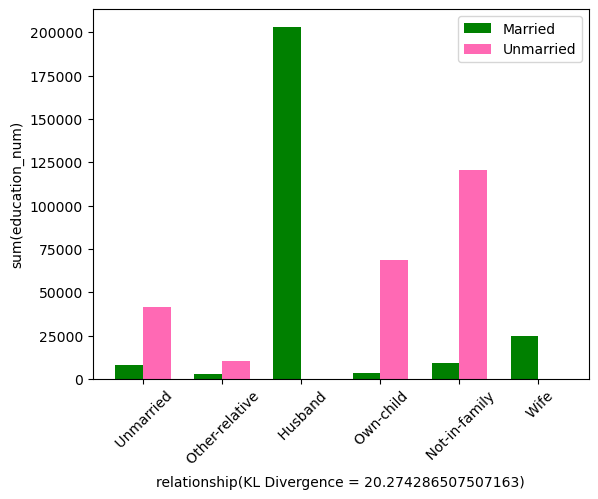

CPU times: total: 609 ms
Wall time: 1.41 s


In [39]:
%%time
top_k_views = sharing_based_multiple_group_by(cursor, all_views, -1, -1, top_k=5)
visualize(cursor, top_k_views)

## Pruning

In [40]:

def pruning_based_optimization(cur, all_views, search_method, num_partitions=15, top_k=5):

    part_size = get_partition_size(cur, num_partitions)

    current_views = list(all_views)

    mean_estimated_utility = {}

    for offset in range(num_partitions):

        results = search_method(cur, current_views, offset, part_size, top_k=None)

        for view, utility_score in results:
            if view not in mean_estimated_utility:
                mean_estimated_utility[view] = 0.0
            mean_estimated_utility[view] += (utility_score - mean_estimated_utility[view]) / (offset + 1)

        sorted_views = sorted(current_views, key=lambda view: mean_estimated_utility.get(view, 0.0))

        max_utility = mean_estimated_utility.get(sorted_views[-1], 0.0)
        kth_utility = mean_estimated_utility.get(sorted_views[-top_k], 0.0) / max_utility if top_k > 0 else 0.0

        if offset == 0:
            print("Iteration 0: Skip")
            continue

        epsilon_m = hoeffding_serfling(offset + 1, num_partitions, 0.1)

        not_pruned_views = []

        for view in current_views:
            est_util = mean_estimated_utility.get(view, 0.0) / max_utility
            if (est_util + epsilon_m) >= (kth_utility - epsilon_m):
                not_pruned_views.append(view)

        pruned_count = len(current_views) - len(not_pruned_views)

        print("Iteration {}: Pruned {} views".format(offset, pruned_count))

        current_views = list(not_pruned_views)

    print("Final count of views: ", len(current_views))

    return search_method(cur, current_views, -1, -1, top_k=top_k)


Iteration 0: Skip
Iteration 1: Pruned 0 views
Iteration 2: Pruned 200 views
Iteration 3: Pruned 10 views
Iteration 4: Pruned 11 views
Iteration 5: Pruned 3 views
Iteration 6: Pruned 0 views
Iteration 7: Pruned 2 views
Iteration 8: Pruned 0 views
Iteration 9: Pruned 0 views
Iteration 10: Pruned 1 views
Iteration 11: Pruned 0 views
Iteration 12: Pruned 0 views
Iteration 13: Pruned 0 views
Iteration 14: Pruned 0 views
Final count of views:  13


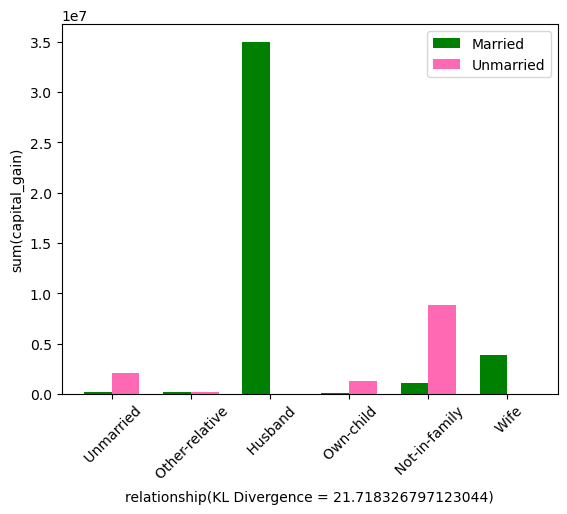

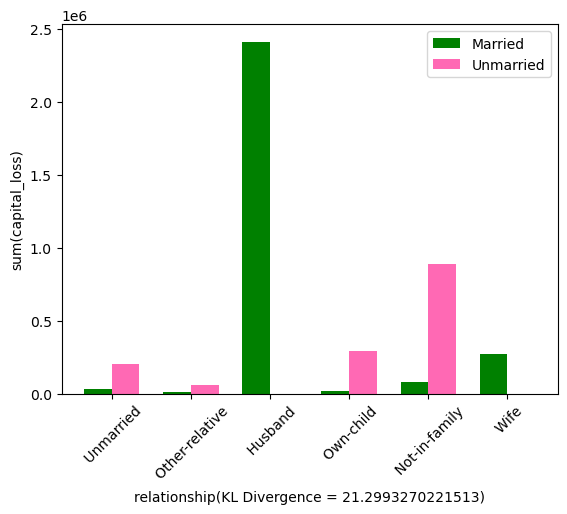

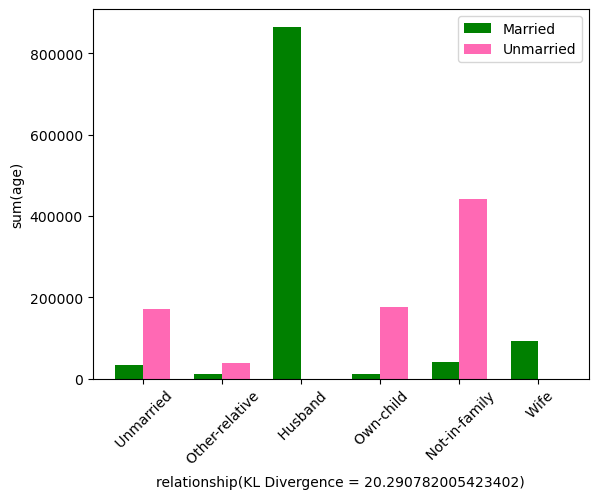

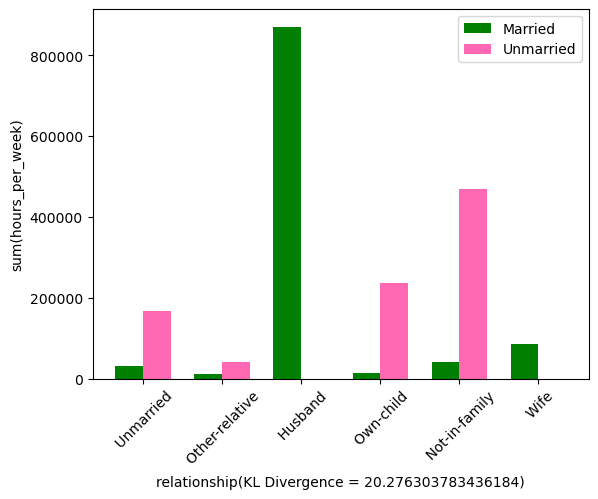

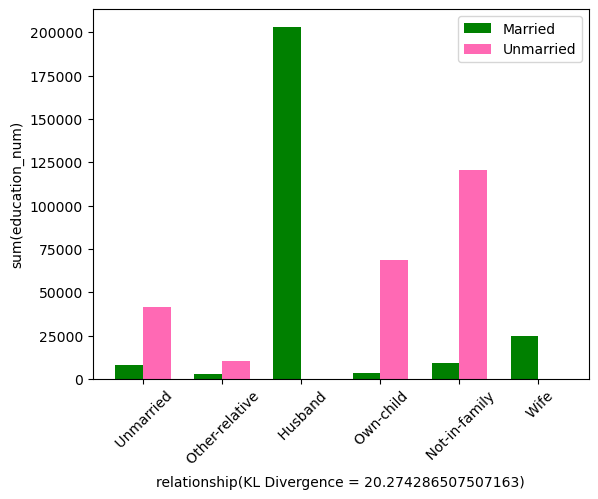

CPU times: total: 516 ms
Wall time: 1min 37s


In [41]:
%%time

#Pruning based on Naive Search Exhaustion
top_k_views = pruning_based_optimization(cursor, all_views, naive_search)
visualize(cursor, top_k_views)

Iteration 0: Skip
Iteration 1: Pruned 0 views
Iteration 2: Pruned 200 views
Iteration 3: Pruned 10 views
Iteration 4: Pruned 11 views
Iteration 5: Pruned 3 views
Iteration 6: Pruned 0 views
Iteration 7: Pruned 2 views
Iteration 8: Pruned 0 views
Iteration 9: Pruned 0 views
Iteration 10: Pruned 1 views
Iteration 11: Pruned 0 views
Iteration 12: Pruned 0 views
Iteration 13: Pruned 0 views
Iteration 14: Pruned 0 views
Final count of views:  13


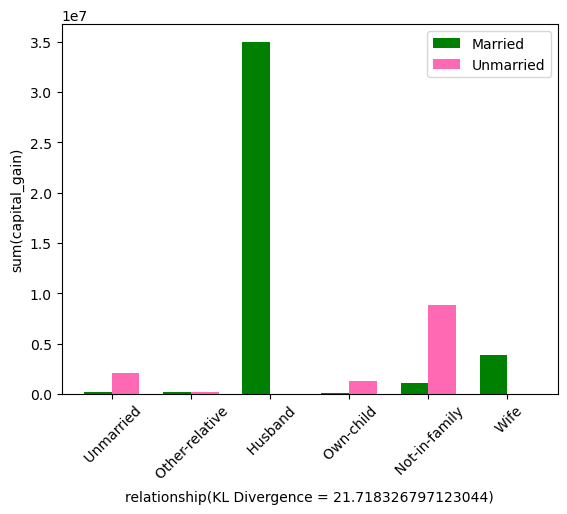

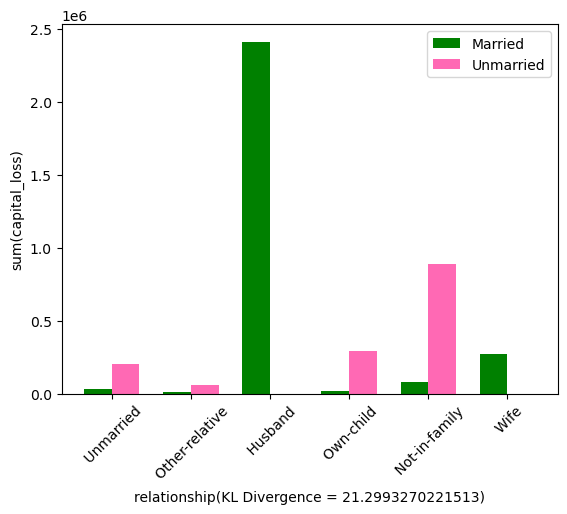

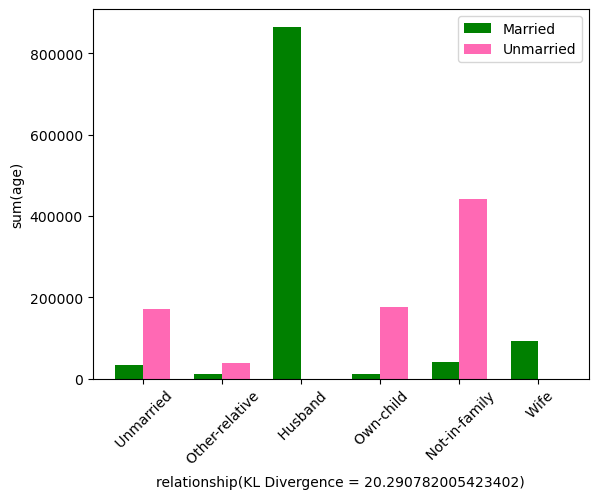

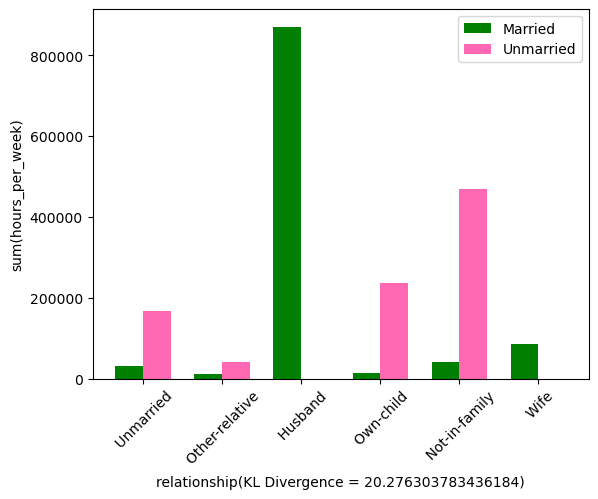

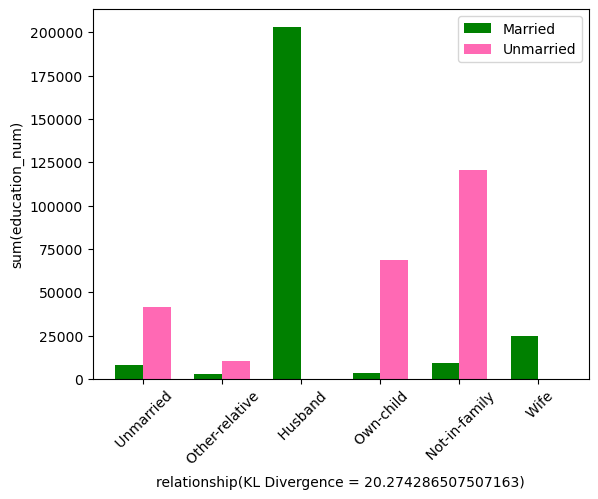

CPU times: total: 438 ms
Wall time: 8.02 s


In [42]:
%%time
#Pruning based on Sharing Based Optimization using combine multiple aggregate
top_k_views = pruning_based_optimization(cursor, all_views, sharing_based_optimization)
visualize(cursor, top_k_views)

Iteration 0: Skip
Iteration 1: Pruned 0 views
Iteration 2: Pruned 200 views
Iteration 3: Pruned 10 views
Iteration 4: Pruned 11 views
Iteration 5: Pruned 3 views
Iteration 6: Pruned 0 views
Iteration 7: Pruned 2 views
Iteration 8: Pruned 0 views
Iteration 9: Pruned 0 views
Iteration 10: Pruned 1 views
Iteration 11: Pruned 0 views
Iteration 12: Pruned 0 views
Iteration 13: Pruned 0 views
Iteration 14: Pruned 0 views
Final count of views:  13


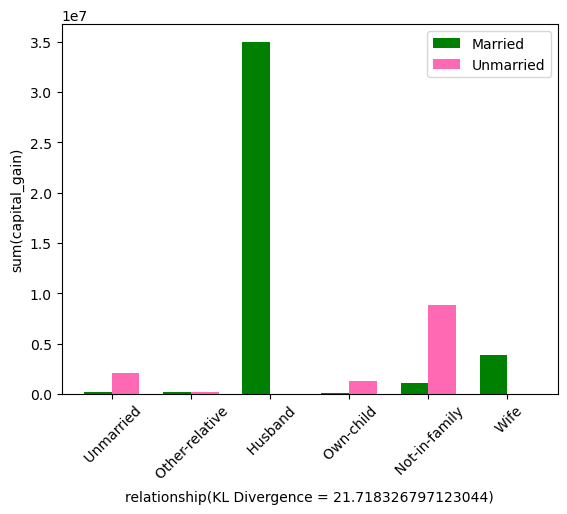

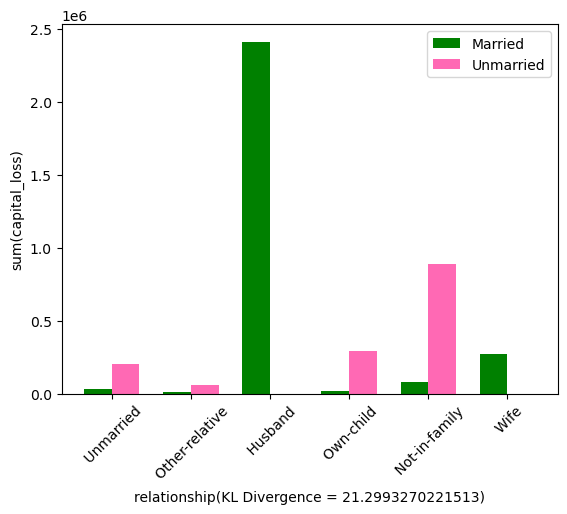

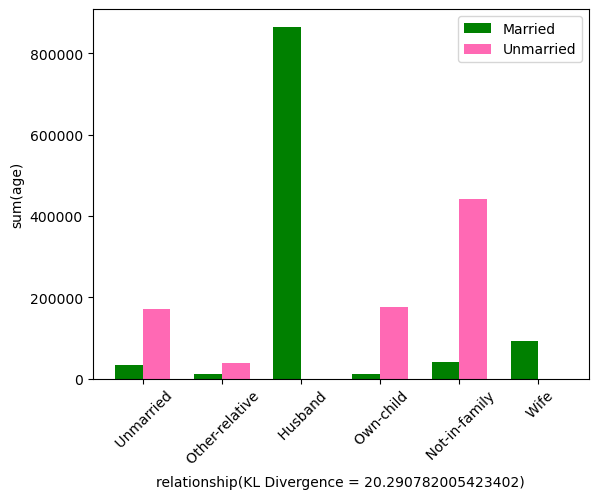

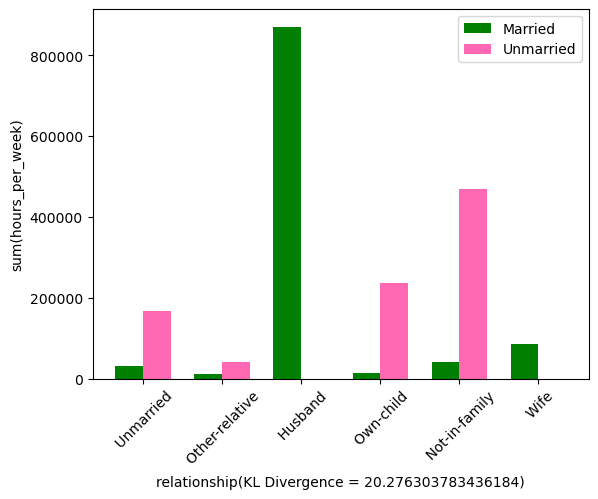

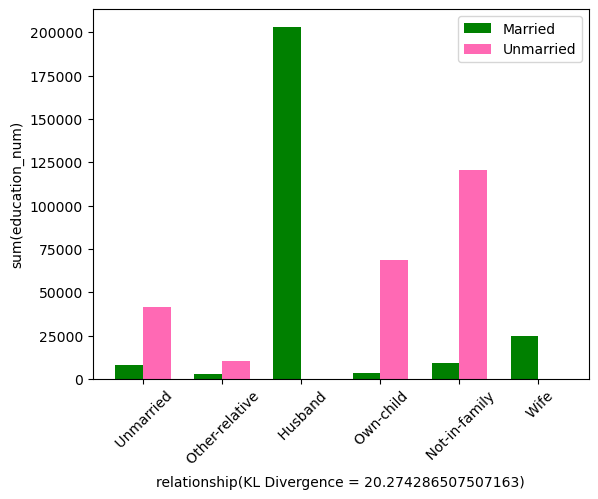

CPU times: total: 547 ms
Wall time: 7.04 s


In [45]:
%%time
#Pruning based on Sharing Based Optimization using combine target and reference query
top_k_views = pruning_based_optimization(cursor, all_views, combine_tar_ref_query)
visualize(cursor, top_k_views)